# Erste deskriptive Analysen für aggregierte Daten

### Datenimport

Importieren und Zusammenfügen der aggregierten Daten von https://www.ckw.ch/lp/opendata.html 

Aggregierte Daten: Summierter Verbrauch pro Zeitfenster pro Gemeinde

In [90]:
%reset

In [91]:
# Verwendete Packages:

import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline
import datetime
import ics
from ics import Calendar
import calendar
from urllib.request import urlopen
from csv_ical import Convert
from dateutil import parser
import seaborn as sns

In [92]:
# Datenimport 2022

dfs22 = {} 
for i in range(202201, 202211):   
    def loadData(month : int = i) -> pd.core.frame.DataFrame :
        url = "https://axsa4prod4publicdata4sa.blob.core.windows.net/$web/ckw_opendata_smartmeter_dataset_b_%i.csv.gz" % month
        return pd.read_csv(url)
    datasetname = i 
    dfs22["dataset{0}".format(i)] = loadData()

In [93]:
# Datenimport 2021

dfs21 = {}
for i in range(202101, 202113):   
    def loadData(month : int = i) -> pd.core.frame.DataFrame :
        url = "https://axsa4prod4publicdata4sa.blob.core.windows.net/$web/ckw_opendata_smartmeter_dataset_b_%i.csv.gz" % month
        return pd.read_csv(url)
    datasetname = i 
    dfs21["dataset{0}".format(i)] = loadData()

In [94]:
# Zusammenfügen

df_data = pd.DataFrame()
df_data = pd.concat([
    dfs22['dataset202201'],
    dfs22['dataset202202'], 
    dfs22['dataset202203'], 
    dfs22['dataset202204'], 
    dfs22['dataset202205'], 
    dfs22['dataset202206'], 
    dfs22['dataset202207'], 
    dfs22['dataset202208'],
    dfs22['dataset202209'],
    dfs22['dataset202210'],
    dfs21['dataset202101'],
    dfs21['dataset202102'], 
    dfs21['dataset202103'], 
    dfs21['dataset202104'], 
    dfs21['dataset202105'], 
    dfs21['dataset202106'], 
    dfs21['dataset202107'], 
    dfs21['dataset202108'],
    dfs21['dataset202109'],
    dfs21['dataset202110'],
    dfs21['dataset202111'],
    dfs21['dataset202112']
], ignore_index=True,axis=0)
df_data
df_data.to_pickle("Dataset.pkl") # Zwischenspeicherung Datenset

### Datenaufbereitung

In [95]:
df_data = pd.read_pickle("Dataset.pkl")

In [96]:
# Formatierung von "timestamp"

df_data['timestamp'] = pd.to_datetime(df_data['timestamp']).dt.tz_convert('Europe/Berlin') # Anpassung Zeitzone auf CET
df_data['timestamp'] = pd.to_datetime(df_data['timestamp'], format="%Y-%m-%dT%H:%M:%S.%fZ", errors = 'coerce') # Formatierung

In [97]:
# Datum-Variablen

df_data['date'] = df_data['timestamp'].dt.date # Datum
df_data["date"] = pd.to_datetime(df_data["date"], format='%Y-%m-%d') # Formatierung Datum
df_data['month'] = df_data['timestamp'].dt.month # Monat
df_data['year'] = df_data['timestamp'].dt.year # Jahr
df_data['timestamp'] = df_data['timestamp'].dt.time # Uhrzeit
df_data['timestamp'] = pd.to_datetime(df_data['timestamp'], format='%H:%M:%S') # Formatierung Uhrzeit
df_data = df_data[~(df_data["year"]=="2020")] # Löschen der (vereinzelten) Werte aus 2020

In [98]:
print(df_data)
df_data.dtypes
df_data.to_pickle("Dataset.pkl") # Zwischenspeicherung Datenset

         area_code           timestamp  num_meter   value_kwh       date  \
0             6028 1900-01-01 12:30:00        131   23.682353 2022-01-28   
1             6028 1900-01-01 22:45:00        130   22.985000 2022-01-20   
2             6028 1900-01-01 14:30:00        130   24.486000 2022-01-04   
3             6028 1900-01-01 13:15:00        131   32.138353 2022-01-27   
4             6028 1900-01-01 10:45:00        130   37.359000 2022-01-14   
...            ...                 ...        ...         ...        ...   
7206399       6263 1900-01-01 19:30:00        442   93.188000 2021-12-14   
7206400       6263 1900-01-01 03:45:00        440  152.357000 2021-12-11   
7206401       6263 1900-01-01 11:30:00        440  104.941000 2021-12-10   
7206402       6263 1900-01-01 03:00:00        440  184.617000 2021-12-10   
7206403       6263 1900-01-01 11:30:00        441   82.090000 2021-12-27   

         month  year  
0            1  2022  
1            1  2022  
2            1  20

### Zusammmenführen mit Gemeindegrössen

Öffentliche Einwohnerzahlen pro PLZ <br>
   * anzahl: Anzahl Einwohner pro PLZ per Stichtag 1.11.2022  <br>
   * typ: m=männlich, w=weiblich, f=firma

In [99]:
# Import öffentlicher Einwohnerzahlen pro PLZ

df_data = pd.read_pickle("Dataset.pkl")   
df_pop = pd.read_csv('https://swisspost.opendatasoft.com/api/v2/catalog/datasets/bevoelkerung_proplz/exports/csv', delimiter= ';')
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9552 entries, 0 to 9551
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   stichdatum  9552 non-null   object 
 1   plz         9549 non-null   float64
 2   anzahl      9552 non-null   int64  
 3   typ         9552 non-null   object 
 4   ortbez18    9546 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 373.2+ KB


In [100]:
# Zusammenführen mit Verbrauchsdaten

df_pop.rename(columns={'plz':'area_code'}, inplace=True) # Umbenennen PLZ-Spalte
df_data = pd.merge(df_data, df_pop, how="left", on=["area_code"]) # Left-join

In [101]:
# Reshape & Bereinigung 

df_data=df_data.pivot(index=['area_code', 'timestamp', 'num_meter', 'value_kwh', 'stichdatum', 'ortbez18', 'date', 'year', 'month'], \
columns='typ', values=['anzahl']).reset_index() # Typ-Kategorien von long- in shor-Format

df_data['num_habits']=df_data['anzahl','f'] + df_data['anzahl','m'] + df_data['anzahl','w'] # Berechnung Anzahl Einwohner pro Gemeinde
df_data.columns = df_data.columns.droplevel('typ') # Löschen Index-Hierarchie
del df_data['stichdatum'] # Löschen col Stichdatum
df_data.columns.values[8:11] =['num_f', 'num_m', 'num_w' ] # Umbenennen Variablen


In [102]:
df_data.to_pickle("Dataset01.pkl") # Zwischenspeicherung Datenset
df_data

,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month,num_f,num_m,num_w,num_habits
0,4806,1900-01-01 00:00:00,19,4.45000,Wikon,2021-01-01,2021,1,124,804,779,1707
1,4806,1900-01-01 00:00:00,24,4.69300,Wikon,2021-01-25,2021,1,124,804,779,1707
2,4806,1900-01-01 00:00:00,24,4.78400,Wikon,2021-01-22,2021,1,124,804,779,1707
3,4806,1900-01-01 00:00:00,24,4.92200,Wikon,2021-01-08,2021,1,124,804,779,1707
4,4806,1900-01-01 00:00:00,24,5.08800,Wikon,2021-01-26,2021,1,124,804,779,1707
...,...,...,...,...,...,...,...,...,...,...,...,...
7206399,6344,1900-01-01 23:45:00,925,161.78300,Meierskappel,2022-04-25,2022,4,220,947,907,2074
7206400,6344,1900-01-01 23:45:00,926,151.60475,Meierskappel,2022-09-26,2022,9,220,947,907,2074
7206401,6344,1900-01-01 23:45:00,928,96.54700,Meierskappel,2022-09-01,2022,9,220,947,907,2074
7206402,6344,1900-01-01 23:45:00,928,97.69100,Meierskappel,2022-06-30,2022,6,220,947,907,2074


### Import öffentlicher Wetterdaten 
* tre200d0 = °C Lufttemperatur 2 m über Boden; Tagesmittel
* prestad0 = hPa Luftdruck auf Stationshöhe (QFE); Tagesmittel
    

In [103]:
# Import Daten 2022

df_data = pd.read_pickle("Dataset01.pkl")
df_temp22= pd.read_csv('https://data.geo.admin.ch/ch.meteoschweiz.klima/nbcn-tageswerte/nbcn-daily_LUZ_current.csv', delimiter= ';') 
df_temp22=df_temp22[['tre200d0', 'prestad0', 'station/location', 'date']]
df_temp22["date"] = pd.to_datetime(df_temp22["date"], format='%Y%m%d')
df_temp22.rename(columns={'tre200d0':'daytemp','prestad0': "airpress"}, inplace=True)


In [104]:
# Import Daten 2021

df_temp21= pd.read_csv('https://data.geo.admin.ch/ch.meteoschweiz.klima/nbcn-tageswerte/nbcn-daily_LUZ_previous.csv', delimiter= ';') # 2021
df_temp21=df_temp21[['tre200d0', 'prestad0', 'station/location', 'date']]
df_temp21["date"] = pd.to_datetime(df_temp21["date"], format='%Y%m%d')
df_temp21.rename(columns={'tre200d0':'daytemp','prestad0': "airpress"}, inplace=True)

In [105]:
# Zusammenführen mit Verbrauchsdaten

df_temp = pd.concat([df_temp22, df_temp21], ignore_index=True,axis=0) # Zusammenfügen Wetterdaten 2021 & 2022
df_data = pd.merge(df_data, df_temp, how="left", on=["date"]) # Merge mit Verbrauchsdaten
df_data
df_data.to_pickle("Dataset02.pkl") # Zwischenspeicherung Datenset

### Import Daten zum Smart Meter Rollout

In [106]:
df_data = pd.read_pickle("Dataset02.pkl")

In [107]:
# Auszug von Gemeinde- und PLZ-Daten

df_areas=df_data.sort_values('ortbez18', ascending=False).groupby('area_code').head(1)
df_areas =  df_areas[["area_code", "ortbez18"]]
df_areas=pd.DataFrame(df_areas)
df_areas.to_excel(r'C:\Users\ckw-stea\Desktop\Python\Gemeinden_SM.xlsx', index=False)

In [108]:
# Import Daten zum Smart Meter Rollout 

df_SM = pd.read_excel(r'C:\Users\ckw-stea\Desktop\Python\SM Rollout.xlsx') # Import Daten
df_SM.rename({"PLZ": "area_code"}, axis=1, inplace=True) # Umbenennen PLZ-Spalte
df_data = pd.merge(df_data, df_SM, how="left", on=["area_code"]) # Merge mit Verbrauchsdaten

### Zusätzliche Variablen

In [109]:
#Durchschnittlicher Verbrauch pro Smart Meter pro Gemeinde

df_data['kwh_permeterarea'] = df_data['value_kwh']/df_data['num_meter']

In [110]:
# Durchschnittlicher Verbrauch pro Smart Meter pro 15-min-Zeitfenster

df_data['kwh_perdatetime']=df_data.groupby(['date', 'timestamp'])['value_kwh'].transform('sum') # Total kwh pro Timeframe über alle Gemeinden
df_data['sm_perdatetime']=df_data.groupby(['date', 'timestamp'])['num_meter'].transform('sum') # Anzahl Smart Meter pro Timeframe über alle Gemeinden 
df_data['kwh_persmdt']=df_data['kwh_perdatetime']/df_data['sm_perdatetime'] # kwh pro Timeframe pro Smart Meter


In [111]:
# Ergänzung Saison 

df_data.loc[(df_data['month'] == 12) | (df_data['month'] == 1) | (df_data['month'] == 2) , 'season'] = 'Winter' # Neue Spalte mit "Winter" für Wintermonate
df_data.loc[(df_data['month'] == 3) | (df_data['month'] == 4) | (df_data['month'] == 5) , 'season'] = 'Frühling' # "Frühling" für Frühlingsmonate
df_data.loc[(df_data['month'] == 6) | (df_data['month'] == 7) | (df_data['month'] == 8) , 'season'] = 'Sommer' # "Sommer" für Sommermonate
df_data.loc[(df_data['month'] == 9) | (df_data['month'] == 10) | (df_data['month'] == 11) , 'season'] = 'Herbst' # "Herbst" für Herbstmonate

In [112]:
df_data.to_pickle("Dataset03.pkl") # Zwischenspeicherung Datenset
df_data.sort_values(['date', 'timestamp'])

,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month,num_f,num_m,...,daytemp,airpress,station/location,Start Rollout,Ende Rollout,kwh_permeterarea,kwh_perdatetime,sm_perdatetime,kwh_persmdt,season
0,4806,1900-01-01 00:00:00,19,4.450000,Wikon,2021-01-01,2021,1,124,804,...,1.7,953.9,LUZ,2021-03-26,2021-03-31,0.234211,13521.100398,38951,0.347131,Winter
183333,6005,1900-01-01 00:00:00,112,25.415000,St. Niklausen LU/Luzern,2021-01-01,2021,1,3192,12599,...,1.7,953.9,LUZ,2023-08-01,2023-08-27,0.226920,13521.100398,38951,0.347131,Winter
246813,6010,1900-01-01 00:00:00,93,11.088188,Kriens/Pilatus Kulm,2021-01-01,2021,1,2535,14560,...,1.7,953.9,LUZ,2023-05-25,2023-07-31,0.119228,13521.100398,38951,0.347131,Winter
246814,6010,1900-01-01 00:00:00,1707,199.815000,Kriens/Pilatus Kulm,2021-01-01,2021,1,2535,14560,...,1.7,953.9,LUZ,2023-05-25,2023-07-31,0.117056,13521.100398,38951,0.347131,Winter
310364,6014,1900-01-01 00:00:00,27,10.531000,Luzern,2021-01-01,2021,1,1263,5774,...,1.7,953.9,LUZ,2023-03-27,2023-03-28,0.390037,13521.100398,38951,0.347131,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3760040,6182,1900-01-01 09:30:00,26,2.310000,Escholzmatt,2022-10-24,2022,10,244,1512,...,13.6,964.8,LUZ,2014-01-01,2014-05-01,0.088846,8.410000,131,0.064198,Herbst
6682953,6284,1900-01-01 09:30:00,16,1.170000,Gelfingen/Sulz LU,2022-10-24,2022,10,96,708,...,13.6,964.8,LUZ,2021-06-01,2021-06-11,0.073125,8.410000,131,0.064198,Herbst
1209639,6030,1900-01-01 09:45:00,15,0.610000,Ebikon,2022-10-24,2022,10,1442,8323,...,13.6,964.8,LUZ,2021-09-14,2021-12-06,0.040667,1.240000,26,0.047692,Herbst
1273134,6032,1900-01-01 09:45:00,11,0.630000,Emmen,2022-10-24,2022,10,789,4425,...,13.6,964.8,LUZ,2023-01-30,2023-03-26,0.057273,1.240000,26,0.047692,Herbst


### Grafiken

In [127]:
df_data = pd.read_pickle("Dataset03.pkl")
sns.set_theme() # definiere Seaborn als Plot-Stil

In [128]:
df_data['num_habits']

0          1707
1          1707
2          1707
3          1707
4          1707
           ... 
7206399    2074
7206400    2074
7206401    2074
7206402    2074
7206403    2074
Name: num_habits, Length: 7206404, dtype: int64

##### Durchschnittlicher Verbrauch pro Smart Meter pro Tag 

Text(0, 0.5, 'Ø Stromverbrauch pro Smart Meter pro Tag')

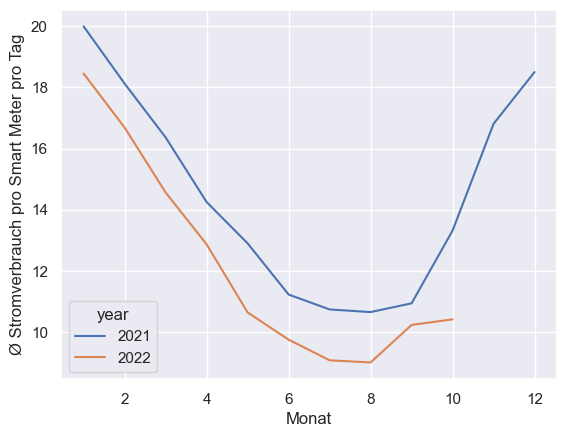

In [114]:
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_day=df_datashort.groupby(['year','month', 'date'])[['kwh_persmdt']].sum() # Verbrauch pro Smart Meter pro Tag

df_day.pivot_table(values="kwh_persmdt", index="month", columns="year").plot()

plt.xlabel("Monat") # X-Label
plt.ylabel("Ø Stromverbrauch pro Smart Meter pro Tag") # Y-Label

#### Durchschnittlicher Verbrauch pro Smart Meter über Tageszeit

<function matplotlib.pyplot.show(close=None, block=None)>

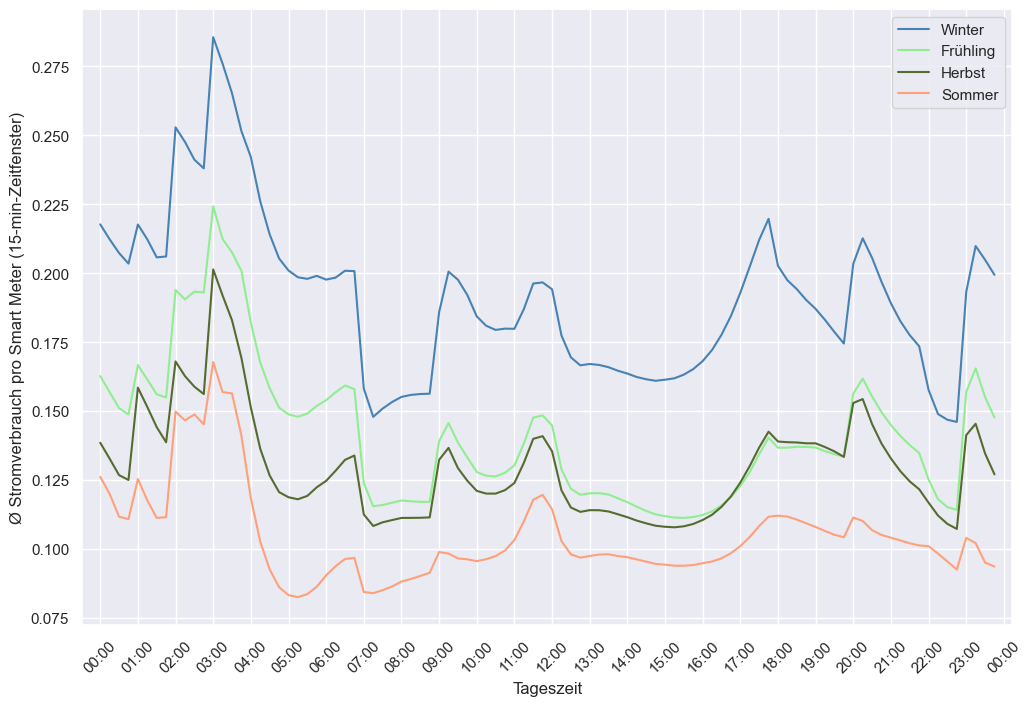

In [115]:
df_time=df_data.pivot_table(values="kwh_persmdt", index="timestamp", columns="season") # Pivot-Tabelle mit durchschnittlichem Verbrauch pro Zeitfenster und Saison

fig, ax = plt.subplots(figsize = (12,8)) # Grafik-Grösse

ax.plot(df_time.index, df_time['Winter'], color = 'steelblue', label='Winter')
ax.plot(df_time.index, df_time['Frühling'], color = 'lightgreen', label='Frühling')
ax.plot(df_time.index, df_time['Herbst'], color = 'darkolivegreen', label='Herbst')
ax.plot(df_time.index, df_time['Sommer'], color = 'lightsalmon', label='Sommer')

plt.xlabel("Tageszeit") # X-Label
plt.ylabel("Ø Stromverbrauch pro Smart Meter (15-min-Zeitfenster)") # Y-Label

ax.xaxis.set_major_locator(md.MinuteLocator(byminute = [0, 60])) # Abstand X-Tick-Labels
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M')) # Format X-Tick-Labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45) # Rotation X-Tick-Labels

plt.margins(x=0.02) # Anpassen Seitenrand
ax.legend() # Hinzufügen Legende

plt.show

#### Effekt CH-Nazi-Spiel

In [116]:
 # Hinzufügen Wochentag

df_data['weekday']= df_data['date'].dt.day_name()
gamedate = datetime.datetime(2022, 5, 22) # Datum Nazi-Spiel
weekday = gamedate.strftime('%A') # Wochentag Nazi-Spiel

In [117]:
# Spalte mit Vergleichstagen für Analyse

df_data.loc[(df_data['month'] == gamedate.month) & (df_data['weekday'] ==  weekday) & (df_data['date']!= gamedate) & (df_data['year']==2022) , 'game'] = 'Vergleich 2022' # Markierung gleiche Wochentage im gleichen Monat 2022
df_data.loc[(df_data['month'] == gamedate.month) & (df_data['weekday'] ==  weekday) &  (df_data['year']==2021), 'game'] = 'Vergleich 2021' # Markeitung gleiche Wochentage im gleichen Monat im 2021
df_data.loc[(df_data['date'] == gamedate) , 'game'] = 'Spieltag' # Markierung Datum Nazi-Spiel

In [118]:
time_range = (df_data['timestamp'].dt.hour >= 12) & (df_data['timestamp'].dt.hour <= 22) # Definition Zeitspanne für Visualisierung
df_game = df_data.loc[time_range] # Datenset-Ausschnitt basierend auf Zeitspanne

<function matplotlib.pyplot.show(close=None, block=None)>

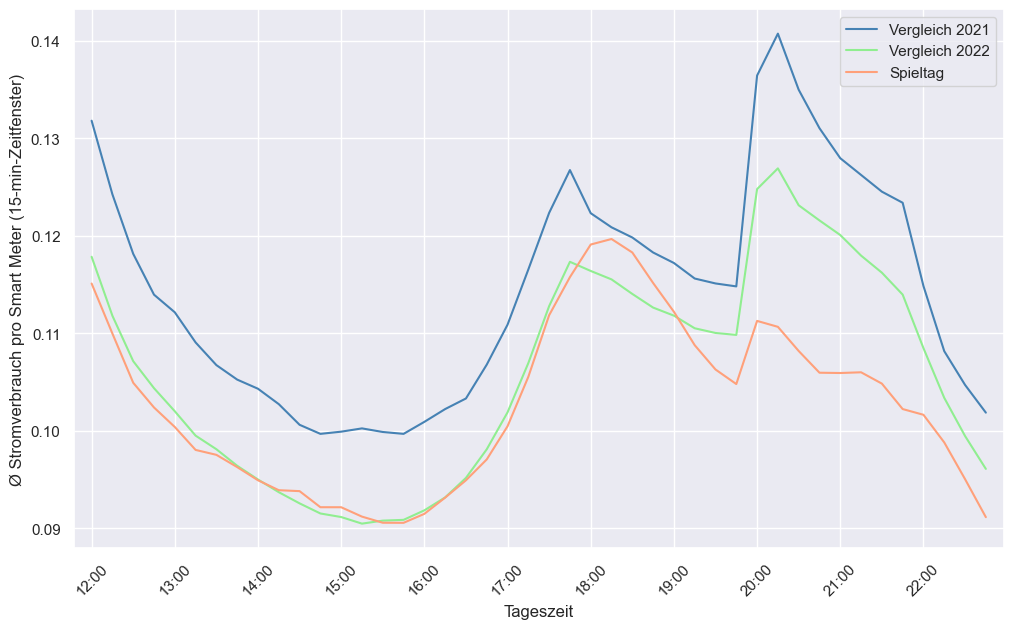

In [119]:
df_game=df_game.pivot_table(values="kwh_persmdt", index="timestamp", columns="game") # Pivot-Tabelle mit durchschnittlichem Verbrauch pro Zeitfenster und Spieltag / Vergleichstage

fig, ax = plt.subplots(figsize = (12,7)) # Grafik-Grösse

ax.plot(df_game.index, df_game['Vergleich 2021'], color = 'steelblue', label='Vergleich 2021')
ax.plot(df_game.index, df_game['Vergleich 2022'], color = 'lightgreen', label='Vergleich 2022')
ax.plot(df_game.index, df_game['Spieltag'], color = 'lightsalmon', label='Spieltag')


plt.xlabel("Tageszeit") # X-Label
plt.ylabel("Ø Stromverbrauch pro Smart Meter (15-min-Zeitfenster)") # Y-Label

ax.xaxis.set_major_locator(md.MinuteLocator(byminute = [0, 60])) # Abstand X-Tick-Labels
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M')) # Format X-Tick-Labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45) # Rotation X-Tick-Labels

plt.margins(x=0.02) # Anpassen Seitenrand
ax.legend() # Hinzufügen Legende

plt.show

#### Durchschnittlicher Verbrauch pro Smart Meter & Tag nach Gemeindegrösse

In [138]:
df_data = pd.read_pickle("Dataset03.pkl") # Neueinlesen Daten 

In [139]:
# Ausschluss PLZ mit Rollout-Ende nach 1.1.2022

df_rollout = df_data[df_data['Ende Rollout'] < datetime.datetime(2022, 1, 1)]
df_rollout.sort_values(by=['Ende Rollout'])

,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month,num_f,num_m,...,daytemp,airpress,station/location,Start Rollout,Ende Rollout,kwh_permeterarea,kwh_perdatetime,sm_perdatetime,kwh_persmdt,season
3623185,6173,1900-01-01 05:45:00,812,130.792000,Flühli LU,2021-05-26,2021,5,135,673,...,12.7,964.3,LUZ,2014-01-01,2014-05-01,0.161074,8503.661210,61667,0.137896,Frühling
3756032,6182,1900-01-01 07:45:00,1607,253.282836,Escholzmatt,2022-01-17,2022,1,244,1512,...,2.5,980.8,LUZ,2014-01-01,2014-05-01,0.157612,15166.635380,91468,0.165814,Winter
3756033,6182,1900-01-01 07:45:00,1607,265.806836,Escholzmatt,2022-01-24,2022,1,244,1512,...,0.7,978.2,LUZ,2014-01-01,2014-05-01,0.165406,15158.384068,92501,0.163873,Winter
3756034,6182,1900-01-01 07:45:00,1607,274.227836,Escholzmatt,2022-01-14,2022,1,244,1512,...,-1.9,980.5,LUZ,2014-01-01,2014-05-01,0.170646,15960.989692,91166,0.175076,Winter
3756035,6182,1900-01-01 07:45:00,1607,274.311836,Escholzmatt,2022-01-25,2022,1,244,1512,...,-0.6,978.8,LUZ,2014-01-01,2014-05-01,0.170698,15401.005712,92820,0.165923,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226145,6030,1900-01-01 15:45:00,8119,732.661036,Ebikon,2022-09-26,2022,9,1442,8323,...,11.9,955.8,LUZ,2021-09-14,2021-12-06,0.090240,10172.567987,106049,0.095923,Herbst
1226144,6030,1900-01-01 15:45:00,8117,706.376000,Ebikon,2022-05-31,2022,5,1442,8323,...,14.7,961.1,LUZ,2021-09-14,2021-12-06,0.087024,10242.109623,104687,0.097836,Frühling
1226143,6030,1900-01-01 15:45:00,8117,647.118250,Ebikon,2022-09-01,2022,9,1442,8323,...,16.7,964.3,LUZ,2021-09-14,2021-12-06,0.079724,8940.484736,105925,0.084404,Herbst
1226156,6030,1900-01-01 15:45:00,8140,795.277750,Ebikon,2022-09-29,2022,9,1442,8323,...,9.2,950.6,LUZ,2021-09-14,2021-12-06,0.097700,11444.144717,106552,0.107404,Herbst


In [140]:
# Ausschluss Verbrauchsdaten vor 1.1.2022

df_rollout = df_rollout[df_data['date'] >= datetime.datetime(2022, 1, 1)]
df_rollout.sort_values(by=['date'])

C:\Users\ckw-stea\AppData\Local\Temp\ipykernel_8104\879334667.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_rollout = df_rollout[df_data['date'] >= datetime.datetime(2022, 1, 1)]
C:\Users\ckw-stea\AppData\Local\Temp\ipykernel_8104\879334667.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_rollout = df_rollout[df_data['date'] < datetime.datetime(2022, 10, 24)] # Auschluss von letztem, unvollständigen Tag in Datenset


,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month,num_f,num_m,...,daytemp,airpress,station/location,Start Rollout,Ende Rollout,kwh_permeterarea,kwh_perdatetime,sm_perdatetime,kwh_persmdt,season
3191116,6147,1900-01-01 10:15:00,566,72.429000,Altbüron,2022-01-01,2022,1,105,630,...,3.6,974.1,LUZ,2021-02-10,2021-02-14,0.127966,12659.663338,89992,0.140675,Winter
517121,6017,1900-01-01 06:00:00,3318,492.427837,Ruswil,2022-01-01,2022,1,573,3521,...,3.6,974.1,LUZ,2020-10-12,2020-11-03,0.148411,15633.289355,89992,0.173719,Winter
1364784,6033,1900-01-01 20:15:00,3044,571.938000,Buchrain,2022-01-01,2022,1,451,3302,...,3.6,974.1,LUZ,2021-08-23,2021-09-13,0.187890,17736.336338,89992,0.197088,Winter
3054400,6145,1900-01-01 05:45:00,344,60.634000,Fischbach LU,2022-01-01,2022,1,50,404,...,3.6,974.1,LUZ,2021-02-04,2021-02-07,0.176262,15681.115355,89992,0.174250,Winter
3014276,6144,1900-01-01 14:15:00,1014,124.801604,Zell LU,2022-01-01,2022,1,218,1085,...,3.6,974.1,LUZ,2021-02-01,2021-02-07,0.123079,10653.692838,89991,0.118386,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205462,6030,1900-01-01 08:00:00,8098,582.774750,Ebikon,2022-10-23,2022,10,1442,8323,...,13.8,963.1,LUZ,2021-09-14,2021-12-06,0.071965,9201.899000,106118,0.086714,Herbst
6959349,6288,1900-01-01 22:45:00,621,75.065250,Schongau,2022-10-23,2022,10,132,612,...,13.8,963.1,LUZ,2021-06-02,2021-06-06,0.120878,9644.156214,106031,0.090956,Herbst
6577515,6280,1900-01-01 17:30:00,194,34.761000,Hochdorf/Urswil,2022-10-23,2022,10,1082,5531,...,13.8,963.1,LUZ,2021-06-11,2021-06-24,0.179180,13273.215000,106505,0.124625,Herbst
6694175,6284,1900-01-01 13:30:00,718,68.412750,Gelfingen/Sulz LU,2022-10-23,2022,10,96,708,...,13.8,963.1,LUZ,2021-06-01,2021-06-11,0.095282,9956.602000,106505,0.093485,Herbst


In [141]:
df_rollout['kwh_perDay'] = df_rollout.groupby(['area_code', 'date'])['kwh_permeterarea'].transform(np.sum) # Totaler Verbrauch pro Meter pro Datum pro Gemeinde
df_rollout['mean_perArea_perDay'] = df_rollout.groupby(['area_code'])['kwh_perDay'].transform(np.mean) # durchschnittlicher Verbrauch pro Meter pro Tag pro Gemeinde 2022

Text(0, 0.5, 'Ø Stromverbrauch pro Smart Meter pro Tag 2022')

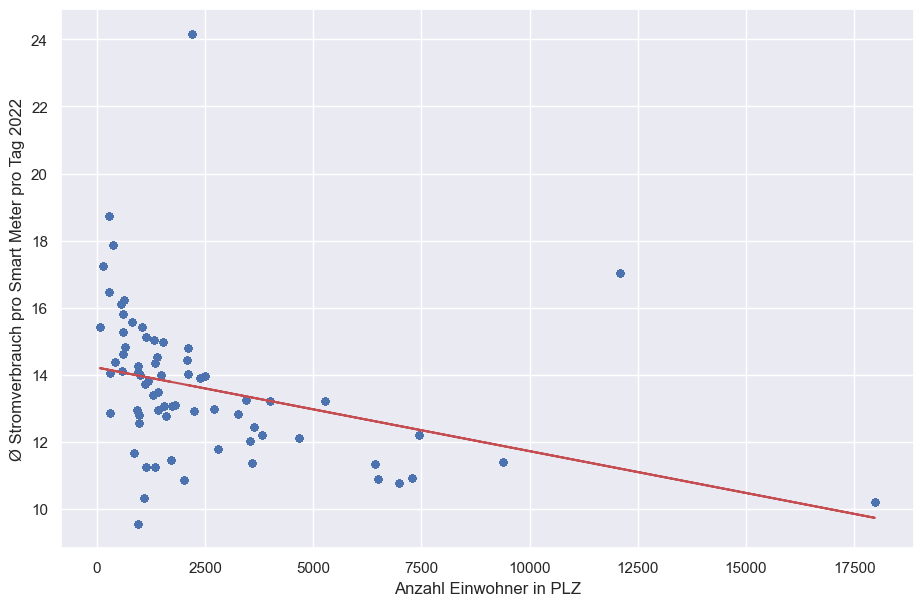

In [142]:
df_rollout.plot.scatter(x = "num_habits", y = 'mean_perArea_perDay', figsize = (11, 7)) # Scatterplot Gemeindegrösse & Verbrauch pro Smart Meter pro Tag 

m, b = np.polyfit(df_rollout["num_habits"], df_rollout["mean_perArea_perDay"], 1) # Korrelationsgerade; m = slope, b=intercept
plt.plot(df_rollout["num_habits"], m*df_rollout["num_habits"] + b, color="r") # Hinzufügen Korrelation zu Grafik

plt.xlabel("Anzahl Einwohner in PLZ") # Umbenennen X-Achse
plt.ylabel("Ø Stromverbrauch pro Smart Meter pro Tag 2022") # Umbenennen Y-Achse

#### Top 10 / Bottom 10 Gemeinden

In [132]:
df_area=df_rollout.groupby(['area_code', 'ortbez18', 'num_habits'])[['kwh_perDay']].mean() # Durchschnittlicher Tagesverbrauch pro Gemeinde 2022
print(df_area.nlargest(10, 'kwh_perDay')) # Top 10
print(df_area.nsmallest(10, 'kwh_perDay')) # Bottom 10

                                      kwh_perDay
area_code ortbez18        num_habits            
6133      Hergiswil LU    2187         24.145436
6028      Herlisberg      288          18.710399
6114      Steinhuserberg  362          17.869607
6132      Rohrmatt        139          17.245505
6280      Hochdorf/Urswil 12078        17.025779
6126      Daiwil          273          16.443661
6113      Romoos          626          16.210831
6019      Sigigen         560          16.091285
6125      Menzberg        601          15.808981
6145      Fischbach LU    806          15.550578
                                                              kwh_perDay
area_code ortbez18                                num_habits            
6035      Perlen                                  955           9.544681
6030      Ebikon                                  17978        10.191236
4915      St. Urban                               1088         10.314788
6033      Buchrain                             

#### Temperatur und Verbrauch

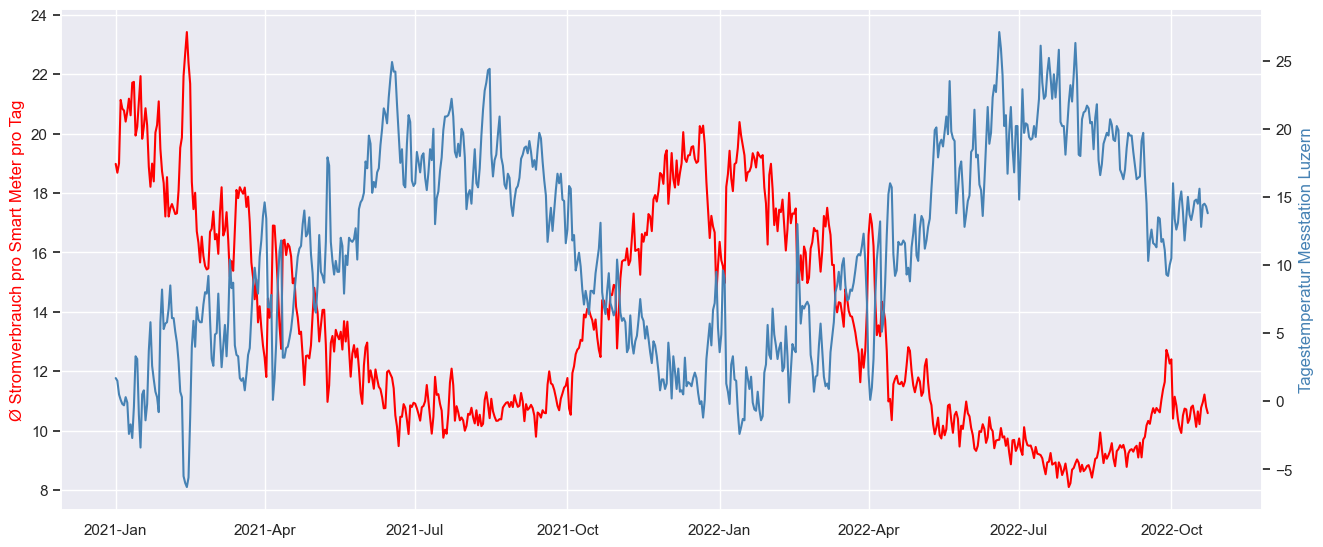

In [146]:
df_day=df_datashort.groupby(['year','month', 'date', 'daytemp'])[['kwh_persmdt']].sum() # Verbrauch pro Smart Meter pro Tag über alle Gemeinden
df_day = df_day.reset_index() # Index-Hierarchie aufheben
df_day = df_day[df_day['date'] < datetime.datetime(2022, 10, 24)] # Auschluss von letztem, unvollständigen Tag in Datenset

col1 = 'red' # Farben definieren
col2 = 'steelblue'

fig,ax = plt.subplots() # Subplots definieren
fig.set_size_inches(15.5, 6.5)

ax.plot(df_day.date, df_day.kwh_persmdt, color=col1) # Verbrauch zum Plot hinzufügen
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%b')) # Format X-Tick-Labels

#ax.set_xlabel('Jahr-Monat', fontsize=12) # X-Achsen-Beschriftung
ax.set_ylabel('Ø Stromverbrauch pro Smart Meter pro Tag', color=col1, fontsize=12) # Y-Achsen-Beschriftung

ax2 = ax.twinx() # zweite Achse definieren
ax2.plot(df_day.date, df_day.daytemp, color=col2) # Temperatur zum Plot hinzufügen
ax2.set_ylabel('Tagestemperatur Messtation Luzern', color=col2, fontsize=12)  # Beschriftung 2. Achse
ax2.grid(False) # keine Hilfslinien für 2. Achse

### Ergänzung von Feiertagen und Ferien

In [154]:
df_data = pd.read_pickle("Dataset03.pkl")

In [155]:
# Import Schulferien-Kalender Kanton Luzern 2021

url = 'https://www.schulferien.org/media/ical/schweiz/ferien_luzern_alle-schulen_2021.ics?k=X1-tbnx2FDD-JES_XUvgkPZvrwnD_7Eg5QILxcWCnN54JcWmszYrnbbROEQwNAlSBe75Tf5i_KEDZXYEyFPYdb2vr5HYCo3dpCMfIHMmWig' 

icsFile = ics.Calendar(urlopen(url).read().decode('iso-8859-1'))
events = icsFile.events

In [156]:
# Import Schulferien-Kalender Kanton Luzern 2022

url = 'https://www.schulferien.org/media/ical/schweiz/ferien_luzern_alle-schulen_2022.ics?k=-HeiXBRn4cEMJC0g6GpsW4cwS7i_b0Hs7tsswy8bHRUVop65bjCsQJsMkxQUCgPrygs9IZeQTkvkKG_P4z_xNkk6Fg0PXj9nDQ7H-z__IKE'

icsFile = ics.Calendar(urlopen(url).read().decode('iso-8859-1'))
school22 = icsFile.events
events.update(school22) # Hinzufügen zu Events
events

{<all-day Event 'Sportferien 2021 Luzern' begin:2021-02-06 end:2021-02-22>,
 <all-day Event 'FrÃ¼hlingsferien 2021 Luzern' begin:2021-04-02 end:2021-04-19>,
 <all-day Event 'Sommerferien 2021 Luzern' begin:2021-07-10 end:2021-08-23>,
 <all-day Event 'Herbstferien 2021 Luzern' begin:2021-10-02 end:2021-10-18>,
 <all-day Event 'Weihnachtsferien 2021 Luzern' begin:2021-12-18 end:2022-01-03>,
 <all-day Event 'Sportferien 2022 Luzern' begin:2022-02-19 end:2022-03-07>,
 <all-day Event 'FrÃ¼hlingsferien 2022 Luzern' begin:2022-04-15 end:2022-05-02>,
 <all-day Event 'Sommerferien 2022 Luzern' begin:2022-07-09 end:2022-08-22>,
 <all-day Event 'Herbstferien 2022 Luzern' begin:2022-10-01 end:2022-10-17>,
 <all-day Event 'Weihnachtsferien 2022 Luzern' begin:2022-12-09 end:2022-12-10>,
 <all-day Event 'Weihnachtsferien 2022 Luzern' begin:2022-12-24 end:2023-01-09>}

In [157]:
# Ergänzung Ferien im Datenset

holidayCheck = []
for _datetime in df_data['date']:

    dfDate = int(_datetime.strftime('%Y%m%d')) # Datetime-Variable "date" in String konvertieren
    
    check = False
    for event in events: 
        eventStart = int(event.begin.strftime('%Y%m%d')) # Event-Startdatum in String konvertieren
        eventEnd = int(event.end.strftime('%Y%m%d')) # Event-Enddatum in String konvertieren

        if (dfDate >= eventStart) and (dfDate < eventEnd) : # Check für jedes Datum, ob von Ferien- oder Feiertag betroffen
            holidayCheck.append(1)
            check = True
            break
        else:
            check = False
            
    if check == False:
        holidayCheck.append(0)

df_data = df_data.assign(schoolhol = holidayCheck) # Neue Spalte mit Ferienindikator

In [152]:
# Import Feiertagskalender Kanton Luzern 2021

url = 'https://www.schulferien.org/media/ical/schweiz/feiertage_luzern_2021.ics?k=6LaiL2FVxUpK0nKXOZLWVBXS4KTyruz76LOzri9flPxd5iwVANFz74HoRBUszjAk-JWoWFNCyNqJqdsRaVvo1UUSHV7Ssevj85XsPpCQUtA' 

icsFile = ics.Calendar(urlopen(url).read().decode('iso-8859-1'))
events = icsFile.events

In [153]:
# Import Feiertagskalender Kanton Luzern 2022

url = 'https://www.schulferien.org/media/ical/schweiz/feiertage_luzern_2022.ics?k=Lmxggzt9kYC0jKx4fu-BijSs_RyNiOdPeXaG-ag_QdWyJloVtnoqL_0w80bdIeZ2SU2DOGB9gOr3ATat4H1IBAa1Ffa0y89pEnD_iYnopgo' 

icsFile = ics.Calendar(urlopen(url).read().decode('iso-8859-1'))
holidays22 = icsFile.events
events.update(holidays22) # Hinzufügen zu Events
events

{<all-day Event 'Neujahr' begin:2021-01-01 end:2021-01-02>,
 <all-day Event 'Sportferien 2021 Luzern' begin:2021-02-06 end:2021-02-22>,
 <all-day Event 'Josefstag' begin:2021-03-19 end:2021-03-20>,
 <all-day Event 'Karfreitag' begin:2021-04-02 end:2021-04-03>,
 <all-day Event 'FrÃ¼hlingsferien 2021 Luzern' begin:2021-04-02 end:2021-04-19>,
 <all-day Event 'Ostermontag' begin:2021-04-05 end:2021-04-06>,
 <all-day Event 'Auffahrt' begin:2021-05-13 end:2021-05-14>,
 <all-day Event 'Pfingstmontag' begin:2021-05-24 end:2021-05-25>,
 <all-day Event 'Fronleichnam' begin:2021-06-03 end:2021-06-04>,
 <all-day Event 'Peter und Paul' begin:2021-06-29 end:2021-06-30>,
 <all-day Event 'Sommerferien 2021 Luzern' begin:2021-07-10 end:2021-08-23>,
 <all-day Event 'Nationalfeiertag' begin:2021-08-01 end:2021-08-02>,
 <all-day Event 'Eidg. Dank-\, Buss- und Bettag' begin:2021-09-19 end:2021-09-20>,
 <all-day Event 'Herbstferien 2021 Luzern' begin:2021-10-02 end:2021-10-18>,
 <all-day Event 'Allerheilige

In [ ]:
# Ergänzung Feiertage im Datenset

holidayCheck = []
for _datetime in df_data['date']:

    dfDate = int(_datetime.strftime('%Y%m%d')) # Datetime-Variable "date" in String konvertieren
    
    check = False
    for event in events: 
        eventStart = int(event.begin.strftime('%Y%m%d')) # Event-Startdatum in String konvertieren
        eventEnd = int(event.end.strftime('%Y%m%d')) # Event-Enddatum in String konvertieren

        if (dfDate >= eventStart) and (dfDate < eventEnd) : # Check für jedes Datum, ob von Ferien- oder Feiertag betroffen
            holidayCheck.append(1)
            check = True
            break
        else:
            check = False
            
    if check == False:
        holidayCheck.append(0)

df_data = df_data.assign(holiday = holidayCheck) # Neue Spalte mit Ferien-/Feiertagindikator

KeyboardInterrupt: 

In [ ]:
df_data.to_pickle("Dataset04.pkl") # Zwischenspeicherung Datenset

In [ ]:
df_data[Holiday].values

,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month,num_f,num_m,...,num_address,daytemp,airpress,station/location,kwh_permeterarea,kwh_perdatetime,sm_perdatetime,kwh_persmdt,season,Holiday
0,4806,1900-01-01 00:00:00,19,4.45000,Wikon,2021-01-01,2021,1,124,804,...,1707,1.7,953.9,LUZ,0.234211,13521.100398,38951,0.347131,Winter,1
1,4806,1900-01-01 00:00:00,24,4.69300,Wikon,2021-01-25,2021,1,124,804,...,1707,0.7,953.1,LUZ,0.195542,10814.948846,47207,0.229096,Winter,0
2,4806,1900-01-01 00:00:00,24,4.78400,Wikon,2021-01-22,2021,1,124,804,...,1707,5.8,943.3,LUZ,0.199333,9171.829166,42452,0.216052,Winter,0
3,4806,1900-01-01 00:00:00,24,4.92200,Wikon,2021-01-08,2021,1,124,804,...,1707,-0.1,962.5,LUZ,0.205083,10115.856275,40186,0.251726,Winter,0
4,4806,1900-01-01 00:00:00,24,5.08800,Wikon,2021-01-26,2021,1,124,804,...,1707,0.3,967.5,LUZ,0.212000,11189.340653,45132,0.247925,Winter,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7206399,6344,1900-01-01 23:45:00,925,161.78300,Meierskappel,2022-04-25,2022,4,220,947,...,2074,9.8,958.0,LUZ,0.174901,14456.019445,104492,0.138346,Frühling,1
7206400,6344,1900-01-01 23:45:00,926,151.60475,Meierskappel,2022-09-26,2022,9,220,947,...,2074,11.9,955.8,LUZ,0.163720,12604.378570,106231,0.118651,Herbst,0
7206401,6344,1900-01-01 23:45:00,928,96.54700,Meierskappel,2022-09-01,2022,9,220,947,...,2074,16.7,964.3,LUZ,0.104038,9141.273673,106204,0.086073,Herbst,0
7206402,6344,1900-01-01 23:45:00,928,97.69100,Meierskappel,2022-06-30,2022,6,220,947,...,2074,20.2,960.5,LUZ,0.105270,9139.271473,105309,0.086785,Sommer,1


In [ ]:
df_data.pivot_table(values='kwh_persmdt', index="date", columns="Holiday")
df = df_data.set_index(['Holiday'])
print(df.loc[1])

         area_code           timestamp  num_meter  value_kwh      ortbez18  \
Holiday                                                                      
1             4806 1900-01-01 00:00:00         19      4.450         Wikon   
1             4806 1900-01-01 00:00:00         24      5.448         Wikon   
1             4806 1900-01-01 00:00:00         25      4.264         Wikon   
1             4806 1900-01-01 00:00:00         25      4.296         Wikon   
1             4806 1900-01-01 00:00:00         25      4.706         Wikon   
...            ...                 ...        ...        ...           ...   
1             6344 1900-01-01 23:45:00        924    126.596  Meierskappel   
1             6344 1900-01-01 23:45:00        924    131.797  Meierskappel   
1             6344 1900-01-01 23:45:00        925     91.505  Meierskappel   
1             6344 1900-01-01 23:45:00        925    161.783  Meierskappel   
1             6344 1900-01-01 23:45:00        928     97.691  Me